# Setting up Project

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM Errors by setting up GPU Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Removing dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data'

In [6]:
os.listdir(data_dir)

['happy', 'sad']

In [7]:
image_exts = ['jpeg','jpg','bmp','png']

In [10]:
image_exts[0]

'jpeg'

In [15]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image not in exts list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with Image {image_path}')
                    

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [37]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 167 files belonging to 2 classes.


In [18]:
data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
data_iterator

In [16]:
batch = data_iterator.next()

In [19]:
len(batch)

2

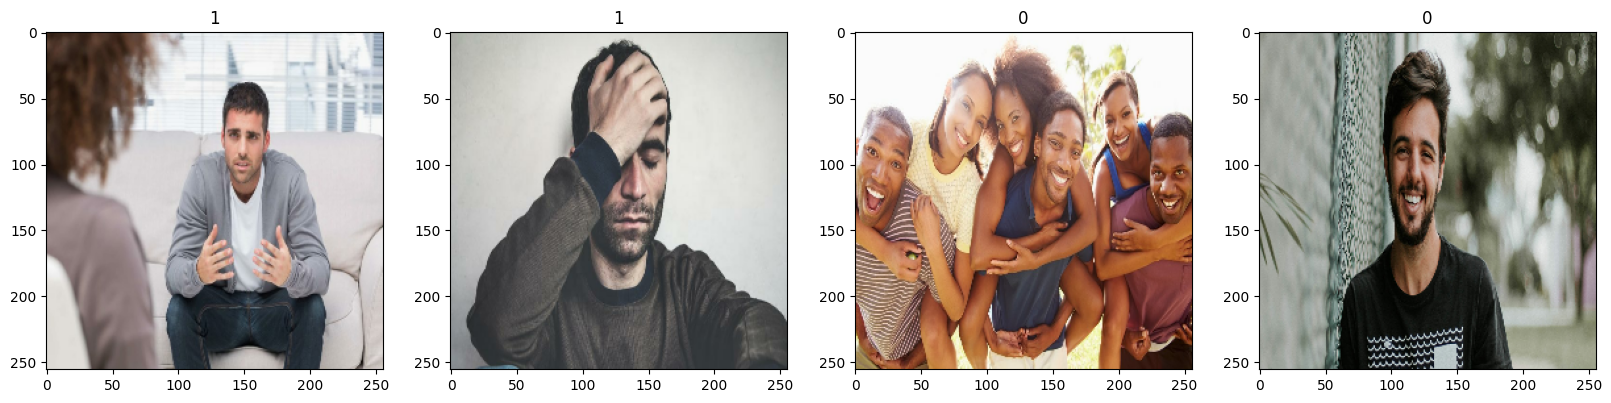

In [20]:
fix, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### From above plots
#### Class 0 --> Happy
#### Class 1 --> Sad

In [25]:
scaled = batch[0] / 255

In [28]:
scaled.max()

1.0

# Preprocessing Data

### Scaling Data

In [38]:
data = data.map(lambda x, y: (x/255, y))

In [39]:
data.as_numpy_iterator().next()

(array([[[[0.63529414, 0.63529414, 0.6375    ],
          [0.6392157 , 0.6392157 , 0.6392157 ],
          [0.63529414, 0.63529414, 0.63529414],
          ...,
          [0.8117647 , 0.78431374, 0.7529412 ],
          [0.80784315, 0.78039217, 0.7490196 ],
          [0.8117647 , 0.78431374, 0.7529412 ]],
 
         [[0.6313726 , 0.6313726 , 0.62352943],
          [0.6313726 , 0.6313726 , 0.6313726 ],
          [0.6313726 , 0.6313726 , 0.6313726 ],
          ...,
          [0.8117647 , 0.78431374, 0.7529412 ],
          [0.8117647 , 0.78431374, 0.7529412 ],
          [0.8156863 , 0.7882353 , 0.75686276]],
 
         [[0.6313726 , 0.6313726 , 0.6313726 ],
          [0.6313726 , 0.6313726 , 0.6313726 ],
          [0.6297794 , 0.6297794 , 0.6297794 ],
          ...,
          [0.80943626, 0.7819853 , 0.75061274],
          [0.8140931 , 0.78664213, 0.7552696 ],
          [0.82193625, 0.7944853 , 0.7631127 ]],
 
         ...,
 
         [[0.360049  , 0.2723039 , 0.16409314],
          [0.23639

In [40]:
scaled_iterator = data.as_numpy_iterator()

In [41]:
batch = scaled_iterator.next()

In [42]:
batch[0].min()

0.0

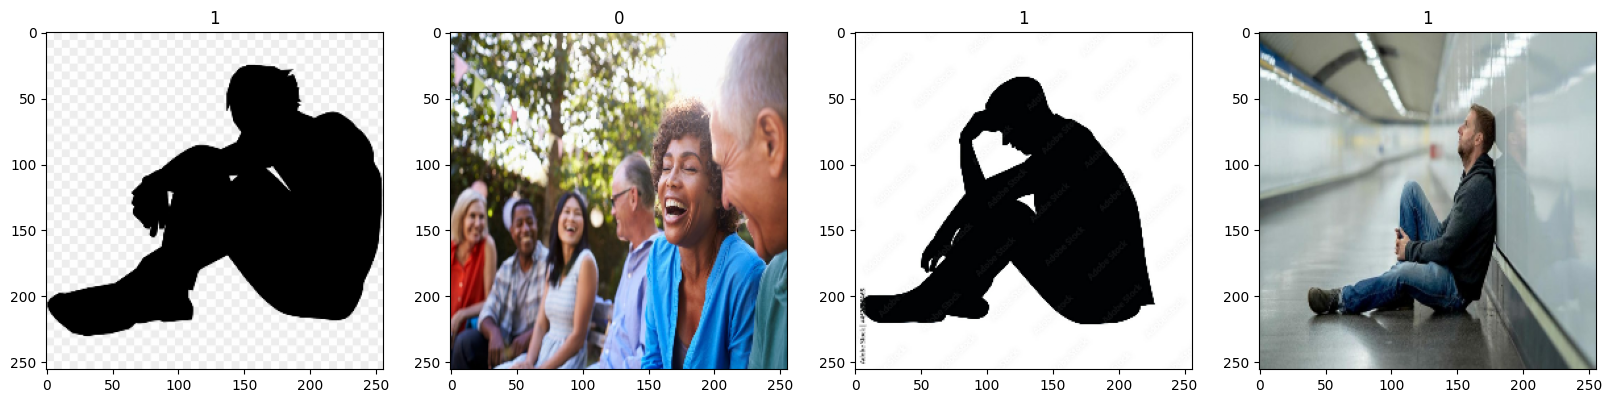

In [43]:
fix, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Splitting the Data

In [44]:
len(data)

6

In [50]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1) + 1

In [55]:
test_size + val_size + train_size

6

In [56]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [59]:
len(test)

1

## Designing and Training the Model

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [61]:
model = Sequential()

In [63]:
model.add(Conv2D(16,(3,3), 1, activation='relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [64]:
model.compile('adam',loss = tf.losses.BinaryCrossentropy(), metrics= ['accuracy'])

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [66]:
logdir = 'logs'

In [67]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [69]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 10s 2s/step - loss: 0.8617 - accuracy: 0.5234 - val_loss: 0.6060 - val_accuracy: 0.6875
Epoch 2/20
4/4 [==============================] - 8s 2s/step - loss: 0.5992 - accuracy: 0.6172 - val_loss: 0.5498 - val_accuracy: 0.6562
Epoch 3/20
4/4 [==============================] - 8s 2s/step - loss: 0.5745 - accuracy: 0.6875 - val_loss: 0.4999 - val_accuracy: 0.8750
Epoch 4/20
4/4 [==============================] - 8s 2s/step - loss: 0.5094 - accuracy: 0.7578 - val_loss: 0.4840 - val_accuracy: 0.8125
Epoch 5/20
4/4 [==============================] - 7s 1s/step - loss: 0.4250 - accuracy: 0.8438 - val_loss: 0.4909 - val_accuracy: 0.7812
Epoch 6/20
4/4 [==============================] - 8s 2s/step - loss: 0.4174 - accuracy: 0.7891 - val_loss: 0.4011 - val_accuracy: 0.8125
Epoch 7/20
4/4 [==============================] - 7s 2s/step - loss: 0.3535 - accuracy: 0.9062 - val_loss: 0.3173 - val_accuracy: 0.8750
Epoch 8/20
4/4 [========================

In [70]:
hist.history

{'loss': [0.8616656064987183,
  0.5991565585136414,
  0.5745189189910889,
  0.5094193816184998,
  0.42495638132095337,
  0.4173579812049866,
  0.3535279631614685,
  0.2843813896179199,
  0.22493839263916016,
  0.1419658660888672,
  0.09655392169952393,
  0.0941908210515976,
  0.05570526793599129,
  0.04185015708208084,
  0.04480796307325363,
  0.017824148759245872,
  0.01359840203076601,
  0.004023788496851921,
  0.005808001384139061,
  0.004113002680242062],
 'accuracy': [0.5234375,
  0.6171875,
  0.6875,
  0.7578125,
  0.84375,
  0.7890625,
  0.90625,
  0.875,
  0.9140625,
  0.9765625,
  0.9921875,
  0.984375,
  0.9921875,
  0.9921875,
  0.984375,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.6059517860412598,
  0.5498464703559875,
  0.4999227225780487,
  0.4840033948421478,
  0.4908749759197235,
  0.40111884474754333,
  0.3173220157623291,
  0.2054743468761444,
  0.12374784797430038,
  0.09076225757598877,
  0.05658648535609245,
  0.0803036019206047,
  0.02286004088819027,
  0

## Plotting the Model Metrics

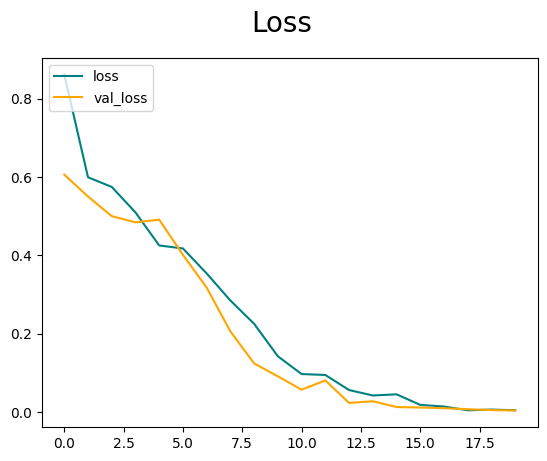

In [71]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

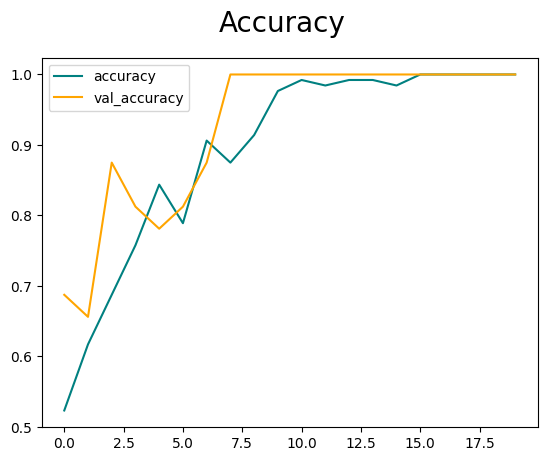

In [72]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

## Evaluating Performance

In [74]:
from tensorflow.keras.metrics import Precision, Recall,  BinaryAccuracy

In [75]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [76]:
len(test)

1

In [77]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    

1/1 [==============================] - 0s 250ms/step


In [78]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


## Testing on Unseen Images

In [79]:
import cv2

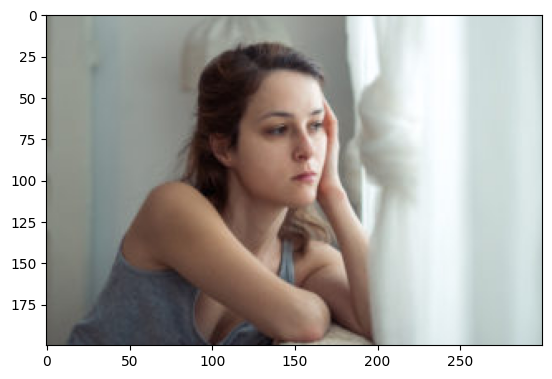

In [91]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

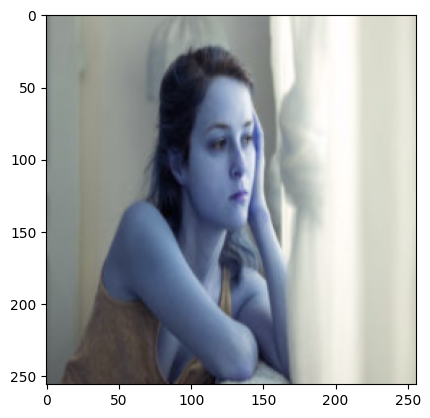

In [92]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [93]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 65ms/step


In [94]:
yhat

array([[0.92914367]], dtype=float32)

In [95]:
if yhat > 0.5:
    print('Predicted Class is Sad')
else:
    print('Predicted Class is Happy')

Predicted Class is Sad


## Saving the Model

In [96]:
from tensorflow.keras.models import load_model

In [97]:
model.save(os.path.join('models', 'happysadclassifier.h5'))

In [98]:
new_model = load_model(os.path.join('models','happysadclassifier.h5'))

In [ ]:
new_model.predict(np.expand_dims(resize/255,0))